# **Stock  prediction**

## Import libraries

In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import r2_score

## Import dataset

In [2]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 1, 1)

In [3]:
import pandas_datareader.data as web
data = web.DataReader("F", 'yahoo', start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,12.66,12.50,12.52,12.66,20773300.0,10.890413
2018-01-03,12.80,12.67,12.68,12.76,29765600.0,10.976439
2018-01-04,13.04,12.77,12.78,12.98,37478200.0,11.165686
2018-01-05,13.22,13.04,13.06,13.20,46121900.0,11.354935
2018-01-08,13.22,13.11,13.21,13.15,33828300.0,11.311922


In [4]:
data.shape

(756, 6)

<AxesSubplot:xlabel='Date'>

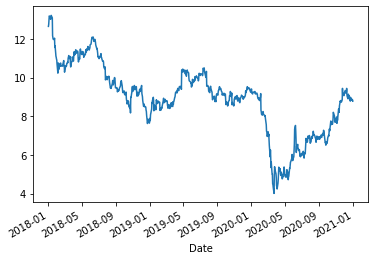

In [5]:
data['Close'].plot()

## Data exponential smoothing

In [6]:
data = data.ewm(span=12).mean()

<AxesSubplot:xlabel='Date'>

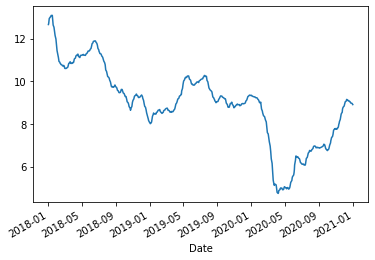

In [7]:
data['Close'].plot()

## Define  and get indicators

In [8]:
# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [9]:
def _get_indicator_data(data):

#     Function that uses the finta API to calculate technical indicators used as the features
#     :return:

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual Volume value (which changes over time), we normalize it with a moving Volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    return data

data_ind = _get_indicator_data(data)
print(data_ind.columns)

Index(['Close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [10]:
data_ind.head()

,Close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,12.660000,NaN,0.000000,0.000000,NaN,3.323725e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-03,12.714167,100.0,0.001215,0.000675,NaN,2.589247e+06,NaN,NaN,NaN,NaN,2.564413e+07,66.666667,NaN,NaN,NaN,1.002114,1.002085,1.002061,1.001940,1.094494
2018-01-04,12.817921,100.0,0.004766,0.002352,NaN,1.579602e+06,NaN,NaN,NaN,NaN,5.590710e+07,100.000000,NaN,NaN,NaN,1.006769,1.006658,1.006564,1.006090,1.158027
2018-01-05,12.938529,100.0,0.010619,0.005152,NaN,1.277310e+06,NaN,NaN,NaN,NaN,9.117611e+07,107.474080,NaN,NaN,NaN,1.012010,1.011761,1.011551,1.010496,1.213073
2018-01-08,12.995985,100.0,0.015861,0.008338,NaN,-3.062365e+06,NaN,NaN,NaN,NaN,1.260537e+08,103.725580,NaN,NaN,NaN,1.013026,1.012649,1.012332,1.010763,1.136402


## Now comes one of the most important part of this project — computing the truth values. 

In [11]:
def _produce_prediction(data, window):
#     Function that produces the 'truth' values
#     At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data_ind = _produce_prediction(data_ind, window = 1)
del (data_ind['Close'])
data_ind = data_ind.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data_ind.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2020-12-23,73.505109,0.207059,0.265917,28.130890,-1.650887e+10,0.205159,-0.146975,34.535795,-0.720035,-2.094757e+09,-10.830300,0.000006,0.993654,1.007120,1.149123,1.056509,1.027427,0.996940,0.967695,0.0
2020-12-24,69.913231,0.188345,0.250402,25.251300,-1.653583e+10,0.205245,-0.164363,27.800084,-1.266873,-2.152211e+09,-38.575096,-0.000011,1.017120,0.982464,1.142989,1.051308,1.023176,0.995381,0.902294,0.0
2020-12-28,67.635400,0.170394,0.234401,22.338895,-1.656288e+10,0.204658,-0.159077,21.095086,-2.006950,-2.206682e+09,-66.090724,-0.000021,1.033321,0.969548,1.138016,1.047269,1.020079,0.994823,0.876575,0.0
2020-12-29,64.044702,0.152561,0.218033,19.695489,-1.658994e+10,0.204051,-0.148449,14.378597,-2.203669,-2.258548e+09,-101.867767,-0.000032,1.049820,0.953153,1.132112,1.042483,1.016292,0.993561,0.858305,0.0
2020-12-30,61.998312,0.135797,0.201586,18.217502,-1.661588e+10,0.202549,-0.170226,7.495286,-2.138323,-2.308351e+09,-123.597743,-0.000047,1.073392,0.934025,1.127556,1.039009,1.013791,0.993403,0.849060,0.0


Because we used Pandas’ shift() function, we lose about 10 rows from the end of the dataset

<AxesSubplot:xlabel='Date'>

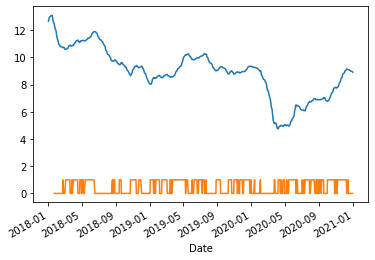

In [12]:
data['Close'].plot()
data_ind['pred'].plot()

Before getting any further we keep a bit of data to try and predict future values

In [28]:
data_live_pred = data_ind.truncate(before = pd.Timestamp('2020-12-19'), after = pd.Timestamp('2020-12-30'))
data_live_pred.head()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2020-12-21,80.294946,0.245820,0.294375,49.990836,-1.644820e+10,0.206285,-0.022799,48.814644,0.647391,-1.967526e+09,32.880036,0.000036,0.953869,1.056708,1.161554,1.067395,1.036507,1.000362,0.997921,0.0
2020-12-22,73.949349,0.225655,0.280631,32.847453,-1.648173e+10,0.205318,-0.090061,41.578877,-0.391100,-2.031936e+09,8.193802,0.000021,0.974162,1.030547,1.152922,1.059692,1.029765,0.996642,0.985789,0.0
2020-12-23,73.505109,0.207059,0.265917,28.130890,-1.650887e+10,0.205159,-0.146975,34.535795,-0.720035,-2.094757e+09,-10.830300,0.000006,0.993654,1.007120,1.149123,1.056509,1.027427,0.996940,0.967695,0.0
2020-12-24,69.913231,0.188345,0.250402,25.251300,-1.653583e+10,0.205245,-0.164363,27.800084,-1.266873,-2.152211e+09,-38.575096,-0.000011,1.017120,0.982464,1.142989,1.051308,1.023176,0.995381,0.902294,0.0
2020-12-28,67.635400,0.170394,0.234401,22.338895,-1.656288e+10,0.204658,-0.159077,21.095086,-2.006950,-2.206682e+09,-66.090724,-0.000021,1.033321,0.969548,1.138016,1.047269,1.020079,0.994823,0.876575,0.0


## Splitting the dataset into the Training set and Test set

The data left out for live prediction are removed from the dataset so they won't be involve in training or testing

In [14]:
data_model = data_ind.truncate(after = pd.Timestamp('2020-12-20'))
data_model.shape

(734, 20)

In [15]:
features =  [x for x in data_ind.columns if x not in ['pred']]

In [16]:
y = data_model['pred']
X = data_model[features]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### **Random forest classifier**

In [18]:
forest = RandomForestClassifier()
param_forest = [{'n_estimators': [110, 120, 140, 160, 180, 200]}]

In [19]:
forest_gs = GridSearchCV(estimator = forest, param_grid = param_forest, cv = 10, n_jobs = -1)
forest_gs.fit(X_train, y_train)
best_accuracy_forest = forest_gs.best_score_
best_parameters_forest = forest_gs.best_params_

prediction_forest = forest_gs.predict(X_test)

print("Best Accuracy: {:.2f} %".format(best_accuracy_forest*100))
print("Best Parameters:", best_parameters_forest)

print(classification_report(y_test, prediction_forest))
print(confusion_matrix(y_test, prediction_forest))

Best Accuracy: 81.77 %
Best Parameters: {'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80        76
         1.0       0.77      0.82      0.79        71

    accuracy                           0.80       147
   macro avg       0.80      0.80      0.80       147
weighted avg       0.80      0.80      0.80       147

[[59 17]
 [13 58]]


### **KNN model**

In [20]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}

In [21]:
knn_gs = GridSearchCV(estimator = knn, param_grid = params_knn, cv = 10, n_jobs = -1)
knn_gs.fit(X_train, y_train)
best_accuracy_knn = knn_gs.best_score_
best_parameters_knn = knn_gs.best_params_

prediction_knn = knn_gs.predict(X_test)

print("Best Accuracy: {:.2f} %".format(best_accuracy_knn*100))
print("Best Parameters:", best_parameters_knn)

print(classification_report(y_test, prediction_knn))
print(confusion_matrix(y_test, prediction_knn))

Best Accuracy: 79.39 %
Best Parameters: {'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.74      0.88      0.80        76
         1.0       0.84      0.66      0.74        71

    accuracy                           0.78       147
   macro avg       0.79      0.77      0.77       147
weighted avg       0.79      0.78      0.77       147

[[67  9]
 [24 47]]


### **Voting classifier**

In [22]:
estimators = [('knn', knn), ('forest', forest)]

In [23]:
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)

ensemble.fit(X_train, y_train)
prediction_ensemble = ensemble.predict(X_test)

print("Best Accuracy: {:.2f} %".format(ensemble.score(X_test, y_test)*100))
print(classification_report(y_test, prediction_ensemble))
print(confusion_matrix(y_test, prediction_ensemble))

Best Accuracy: 78.91 %
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80        76
         1.0       0.79      0.76      0.78        71

    accuracy                           0.79       147
   macro avg       0.79      0.79      0.79       147
weighted avg       0.79      0.79      0.79       147

[[62 14]
 [17 54]]


### **Cross validation**

In [24]:
accuracies_forest = cross_val_score(estimator = forest_gs, X = X_train, y = y_train, cv = 10)
accuracies_knn = cross_val_score(estimator = knn_gs, X = X_train, y = y_train, cv = 10)
accuracies_ensemble = cross_val_score(estimator = ensemble, X = X_train, y = y_train, cv = 10)

print("Forest accuracy: {:.2f} %".format(accuracies_forest.mean()*100))
print("KNN accuracy: {:.2f} %".format(accuracies_knn.mean()*100))
print("Ensemble accuracy: {:.2f} %".format(accuracies_ensemble.mean()*100))

Forest accuracy: 81.60 %
KNN accuracy: 79.21 %
Ensemble accuracy: 76.34 %


## Verification

In [25]:
data_live_pred

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2020-12-21,80.294946,0.245820,0.294375,49.990836,-1.644820e+10,0.206285,-0.022799,48.814644,0.647391,-1.967526e+09,32.880036,0.000036,0.953869,1.056708,1.161554,1.067395,1.036507,1.000362,0.997921,0.0
2020-12-22,73.949349,0.225655,0.280631,32.847453,-1.648173e+10,0.205318,-0.090061,41.578877,-0.391100,-2.031936e+09,8.193802,0.000021,0.974162,1.030547,1.152922,1.059692,1.029765,0.996642,0.985789,0.0
2020-12-23,73.505109,0.207059,0.265917,28.130890,-1.650887e+10,0.205159,-0.146975,34.535795,-0.720035,-2.094757e+09,-10.830300,0.000006,0.993654,1.007120,1.149123,1.056509,1.027427,0.996940,0.967695,0.0
2020-12-24,69.913231,0.188345,0.250402,25.251300,-1.653583e+10,0.205245,-0.164363,27.800084,-1.266873,-2.152211e+09,-38.575096,-0.000011,1.017120,0.982464,1.142989,1.051308,1.023176,0.995381,0.902294,0.0
2020-12-28,67.635400,0.170394,0.234401,22.338895,-1.656288e+10,0.204658,-0.159077,21.095086,-2.006950,-2.206682e+09,-66.090724,-0.000021,1.033321,0.969548,1.138016,1.047269,1.020079,0.994823,0.876575,0.0
2020-12-29,64.044702,0.152561,0.218033,19.695489,-1.658994e+10,0.204051,-0.148449,14.378597,-2.203669,-2.258548e+09,-101.867767,-0.000032,1.049820,0.953153,1.132112,1.042483,1.016292,0.993561,0.858305,0.0
2020-12-30,61.998312,0.135797,0.201586,18.217502,-1.661588e+10,0.202549,-0.170226,7.495286,-2.138323,-2.308351e+09,-123.597743,-0.000047,1.073392,0.934025,1.127556,1.039009,1.013791,0.993403,0.849060,0.0


In [29]:
y_live_pred = data_live_pred['pred']
del(data_live_pred['pred'])
prediction = forest_gs.predict(data_live_pred)
print(prediction)

[0. 0. 0. 0. 0. 0. 0.]


In [30]:
print(classification_report(y_live_pred, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

